# Problem Set 1 (40 points) -   Take-Home

You have been tasked to implement a predictor that will _rank_ documents according to their relevancy to a given query. 

You will use the [LETOR 4.0 dataset MQ2007]( https://arxiv.org/pdf/1306.2597.pdf) that has already been downloaded and is available in the `data` folder.

Each row is a query-document pair. The first column is the relevance label of this pair, the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. The larger the relevance label, the more relevant the query-document pair. A query-document pair is represented by a 46-dimensional feature vector. 

## PS1.A (5 points) - Data Exploration

Create a pandas frame of the dataset and _print_ the first 5 rows in format where the first row will show the column names of the dataset. Instead of the feature names you can conveniently use the column index as a name.  

Is the 2nd column which is the query id a feature or not ?  Answer the question by coding the production of the $\mathbf x$ feature container and the $label y$ label container.  

In [6]:
# Insert the code here
import pandas

#Convert whatever the heck this is right to CSV
file_in = open("Querylevelnorm.txt", "r") 
file_out = open("Querylevelnorm.csv", "w")
column_names=["relevance", "qid"]
column_names.extend(str(i + 1) for i in range(46))
file_out.write(",".join(column_names))
file_out.write("\n")
for line in file_in:
    components = line.split(" ")
    components = components[:48]
    for i in range(47):
        components[i+1] = components[i+1].split(":")[1]
    file_out.write(",".join(components))
    file_out.write("\n")



In [7]:
from sklearn.model_selection import train_test_split 

#And now read it into the dataframes for train and test data
dataframe = pandas.read_csv("Querylevelnorm.csv")
print(dataframe.head(5))
train, test = train_test_split(dataframe, test_size=0.2)
X_test = test.drop(["relevance", "qid"], axis=1).iloc[:500]
y_test = test["relevance"].iloc[:500]
X_train = train.drop(["relevance", "qid"], axis=1).iloc[:5000]
y_train = train["relevance"].iloc[:5000]


   relevance  qid         1         2     3         4         5    6    7  \
0          0   10  0.000000  0.000000  0.00  0.000000  0.000000  0.0  0.0   
1          1   10  0.031310  0.666667  0.50  0.166667  0.033206  0.0  0.0   
2          1   10  0.078682  0.166667  0.50  0.333333  0.080022  0.0  0.0   
3          1   10  0.019058  1.000000  1.00  0.500000  0.022591  0.0  0.0   
4          0   10  0.039477  0.000000  0.75  0.166667  0.040555  0.0  0.0   

     8  ...        37        38        39        40        41        42  \
0  0.0  ...  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.0  ...  0.646890  0.686107  0.823908  0.750092  0.385426  0.923077   
2  0.0  ...  0.649824  0.578581  0.868557  0.641385  0.010462  0.076923   
3  0.0  ...  0.918403  0.868457  1.000000  0.863460  0.016642  0.153846   
4  0.0  ...  0.565875  0.569440  0.769845  0.646567  0.073711  0.076923   

         43        44        45   46  
0  0.017241  0.000000  0.000000  0.0  
1  0.086

Looking at the unique values in the qid column, I have concluded that a query ID is not a feature as it is just an integer identifier for the query and does not pertain to any real information about it, per se. In addition, it is definitely not a continuous variable that we can perform regression on. As such, it was dropped from the test and train data.

In [8]:
print(test["qid"].unique())

[ 135 8064 1234 ... 5576 2466 4398]


## PS1.B (20 points)

Consult your textbook notebook `#4`` (the one that corresponds to Chapter 4) and express the problem of ranking as a regression problem. State the problem and implement the solution using the polynomial basis functions just like in [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Solve the linear regression problem using SGD. Report the train and test MSE as a function of the epochs. 


This ranking problem can be turned into a regression problem by treating the ranking as a continuous variable. We can use linear regression by applying a polynomial basis function and then performing linear regression on the transformed dataset. In addition, we will also be normalizing the data such that the means of each input variable and the mean of the output variable are 0, and undoing the normalization when we make predictions. This way we do not have to worry about the intercepts at all during training. Our weights will therefore be represented as a vector, one for each independent variable. Our prediction using $m$ data points will therefore be

$\hat{y_i} = w_1x_{i1} + w_2x_{i2} + ... + w_mx_{im}$

And our error when predicting $n$ data points will be

$Err = \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

Now we derive this with respect to a given weight, say, $w_j$.

$\frac{dErr}{dw_j} = \frac{d}{dw_j} \frac{1}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)^2$

$=\frac{1}{n}\sum_{i=1}^{n} \frac{d}{dw_j} (\hat{y_i}-y_i)^2$

$\frac{d}{dw_j} (\hat{y_i}-y_i)^2 = 2(\hat{y_i}-y_i)(\frac{d}{dw_j}(\hat{y_i}-y_i))$

$\frac{d}{dw_j}(\hat{y_i}-y_i) = \frac{d}{dw_j}\hat{y_i} = \frac{d}{dw_j}w_jx_{ij} = x_{ij}$

$\frac{dErr}{dw_j} = \frac{2}{n}\sum_{i=1}^{n}(\hat{y_i}-y_i)x_{ij}$

In the case of stoachastic gradient descent, we have $n=1$

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j$

We now have the mathematical TRUTH we need to implement SGD from scratch. Even in C if we so chose. In order to verify that we have not made a fatal error in mathematical reasoning or in implementation, we will first test the algorithm on a toy dataset, and then the actual data.

initializing
Training


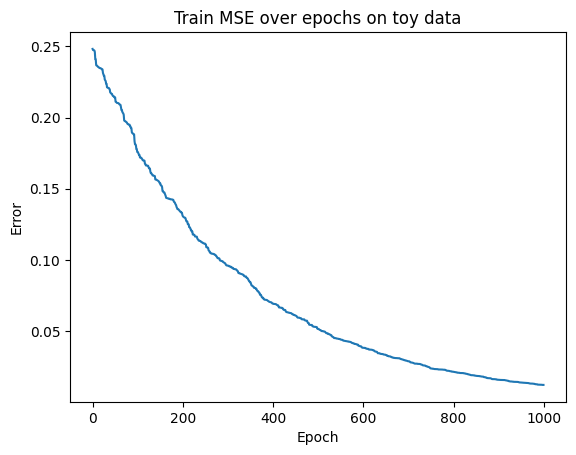

initializing
Training


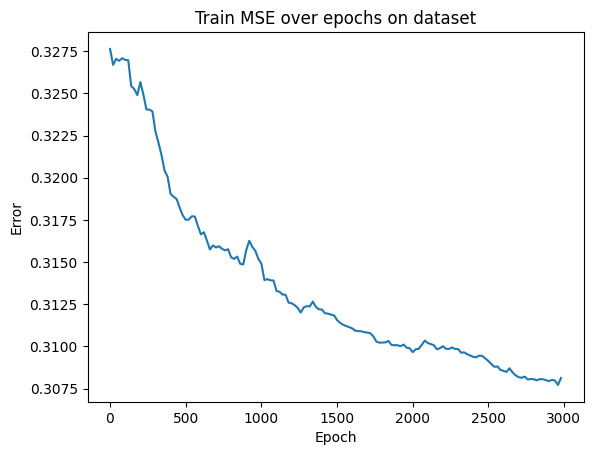

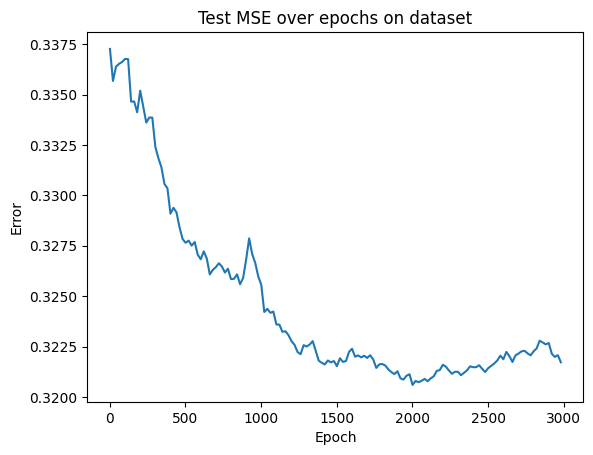

In [9]:
# Insert code here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy
import random
from matplotlib import pyplot as plt

class Model:
    def __init__(self, X: list[list[float]], y: list[float], store_errors: bool = False, error_skip_length: int = 1, X_test: list[list[float]] = None, y_test: list[float] = None):
        assert len(X) > 0
        print("initializing")
        self.store_errors = store_errors
        self.error_skip_length = error_skip_length
        self.errors_train = [] # Will store the MSE as a function of epochs 
        self.errors_test = []
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

        self.X_test = X_test
        self.y_test = y_test
    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors_test = []
        self.errors_train = []
        for i in range(epochs):
                
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] 
                self.coefficients[weight_index] -= learning_rate * gradient

            # Calculate MSE for train and test data and store it
            # This is just for metrics, but unfortunately takes a vast majority
            # of the computational power in this algorithm.
            # As such, I have added an extra parameter, "error_skip_length"
            # This will be used so that it only finds and stores the MSE at every error_skip_length'th epoch.
            if self.store_errors and i % self.error_skip_length == 0:
                if self.X_test != None and self.y_test != None:
                    assert len(self.X_test) > 0
                    assert len(self.X_test[0]) == len(self.X[0])

                    predictions = []
                    for j in range(len(self.X_test)):
                        predictions.append(self.predict(self.X_test[j]))
                    mse = mean_squared_error(self.y_test, predictions)
                    #print("Epoch " + str(i + 1) + " test mse: " + str(mse))
                    self.errors_test.append(mean_squared_error(self.y_test, predictions))
     

                predictions = []
                for j in range(len(self.X)):
                    predictions.append(self.predict_normalized(self.X[j]))
                mse = mean_squared_error(self.y, predictions)
                #print("Epoch " + str(i + 1) + " train mse: " + str(mse))
                self.errors_train.append(mse)
            

#To test the validity of our algorithm, we will test it on some toy data with 3 features
toy_data_x= []
toy_data_y = []
for i in range(10000):
    gen_w = random.random()
    gen_x = random.random()
    gen_z = random.random() + 10
    gen_y = gen_w + gen_x + gen_z + random.random() * 0.2 + 10
    toy_data_x.append([gen_w, gen_x, gen_z])
    toy_data_y.append(gen_y)

model = Model(toy_data_x, toy_data_y, store_errors=True)
model.fit(1000, 0.01)
x_axis = [i for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on toy data")
plt.show()

#Now we will regress on the actual dataset using polynomial basis functions. HERE GOES!!!!
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train).tolist()
y_train_transformed = y_train.values.tolist()

X_test_transformed = poly.fit_transform(X_test).tolist()
y_test_transformed = y_test.values.tolist()

error_skip_length=20
model = Model(X_train_transformed, y_train_transformed, store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
model.fit(3000, 0.0001)

x_axis = [error_skip_length * i + 1 for i in range(len(model.errors_train))]
plt.plot(x_axis, model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset")
plt.show()

plt.plot(x_axis, model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset")
plt.show()

So, we can see that the algorithm performed extremely well on the toy data (which is to be expected as the toy data was basically designed to be well-suited to multiple linear regression). On the actual data, it was still able to do something, but the reduction in MSE was somewhat underwhelming in comparison. The underwhelming reduction in MSE could be partially explained by the fact that the pre-trained model predicts the mean of all relevances as the prediction for relevance by standardizing the data to have a mean of 0 and having a vector of all 0's as the initial weight vector. This in itself is in the ballpark of already being accurate, meaning there was less to improve upon.

## PS1.C (15 points)

Repeat the exercise of PS 1.B with the additional regualrization approach of  [this notebook](https://pantelis.github.io/data-mining/aiml-common/lectures/regression/linear-regression/linear_regression.html). Optimize $\lambda$ showing the train and test MSE as a function of this hyperparameter and for the optimal value of $\lambda$ plot the final train and test MSE as a function of the epochs.

So, when doing linear regression, it looks like we are now adding an extra term $\frac{\lambda}{2}||w||^2$. Our loss function for $m$ features is now

$Err = (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}||w||^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}\sqrt{w_1^2 + w_2^2 + ... + w_m^2}^2$

$= (\hat{y_i}-y_i)^2 + \frac{\lambda}{2}(w_1^2 + w_2^2 + ... + w_m^2)$

To calculate the derivative of this term with respect to a weight $w_j$, it looks like it's just going to be the power rule to give us

$\frac{dErr}{dw_j} = 2(\hat{y}-y)x_j + \lambda w_j$

Which gives us our new gradient.

I will optimize this hyperparameter using optuna.

[I 2023-10-24 17:18:37,015] A new study created in memory with name: no-name-2e17f544-7446-43ab-afd0-917fb7f843a6


initializing


[I 2023-10-24 17:18:39,000] Trial 0 finished with value: 0.3307082293976374 and parameters: {'special_hyperparameter': 47.25367330797212}. Best is trial 0 with value: 0.3307082293976374.


Training
initializing


[I 2023-10-24 17:18:40,970] Trial 1 finished with value: 0.33178093359870103 and parameters: {'special_hyperparameter': 97.36431949372772}. Best is trial 0 with value: 0.3307082293976374.


Training
initializing


[I 2023-10-24 17:18:42,941] Trial 2 finished with value: 0.3284979341431861 and parameters: {'special_hyperparameter': 16.249819687983635}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:44,910] Trial 3 finished with value: 0.3295257759063003 and parameters: {'special_hyperparameter': 39.535434417869034}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing
Training


[I 2023-10-24 17:18:46,878] Trial 4 finished with value: 0.33424330075476893 and parameters: {'special_hyperparameter': 28.430884705218816}. Best is trial 2 with value: 0.3284979341431861.


initializing


[I 2023-10-24 17:18:48,857] Trial 5 finished with value: 0.3324386615869085 and parameters: {'special_hyperparameter': 54.05369456680115}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:50,819] Trial 6 finished with value: 0.33397488851912316 and parameters: {'special_hyperparameter': 70.65105521733355}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:52,789] Trial 7 finished with value: 0.33004423323161464 and parameters: {'special_hyperparameter': 32.79572586172947}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:54,753] Trial 8 finished with value: 0.3358403690012865 and parameters: {'special_hyperparameter': 98.46563597844727}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:56,721] Trial 9 finished with value: 0.3333330139823562 and parameters: {'special_hyperparameter': 99.95556382944983}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:18:58,687] Trial 10 finished with value: 0.333366007775433 and parameters: {'special_hyperparameter': 4.9036918084452825}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing
Training


[I 2023-10-24 17:19:00,667] Trial 11 finished with value: 0.34211634275685116 and parameters: {'special_hyperparameter': 2.821720243992086}. Best is trial 2 with value: 0.3284979341431861.


initializing
Training


[I 2023-10-24 17:19:02,620] Trial 12 finished with value: 0.33151260345540134 and parameters: {'special_hyperparameter': 19.865381516989146}. Best is trial 2 with value: 0.3284979341431861.


initializing
Training


[I 2023-10-24 17:19:04,600] Trial 13 finished with value: 0.328895461880458 and parameters: {'special_hyperparameter': 18.698461538236252}. Best is trial 2 with value: 0.3284979341431861.


initializing
Training


[I 2023-10-24 17:19:06,560] Trial 14 finished with value: 0.32913733414749485 and parameters: {'special_hyperparameter': 17.026699543556948}. Best is trial 2 with value: 0.3284979341431861.


initializing
Training


[I 2023-10-24 17:19:08,529] Trial 15 finished with value: 0.3299092803352605 and parameters: {'special_hyperparameter': 14.857369978017115}. Best is trial 2 with value: 0.3284979341431861.


initializing


[I 2023-10-24 17:19:10,486] Trial 16 finished with value: 0.348815702357006 and parameters: {'special_hyperparameter': 1.0843207621488489}. Best is trial 2 with value: 0.3284979341431861.


Training
initializing


[I 2023-10-24 17:19:12,441] Trial 17 finished with value: 0.32814487305475704 and parameters: {'special_hyperparameter': 24.843653216416403}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:14,413] Trial 18 finished with value: 0.33178153276196626 and parameters: {'special_hyperparameter': 30.05081353438744}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing
Training


[I 2023-10-24 17:19:16,378] Trial 19 finished with value: 0.33408745067840606 and parameters: {'special_hyperparameter': 9.841767245204455}. Best is trial 17 with value: 0.32814487305475704.


initializing
Training


[I 2023-10-24 17:19:18,331] Trial 20 finished with value: 0.3297240068075064 and parameters: {'special_hyperparameter': 22.832465143018013}. Best is trial 17 with value: 0.32814487305475704.


initializing


[I 2023-10-24 17:19:20,292] Trial 21 finished with value: 0.3287488607794677 and parameters: {'special_hyperparameter': 15.034815191419888}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:22,242] Trial 22 finished with value: 0.32850657776139164 and parameters: {'special_hyperparameter': 9.88480013873807}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:24,205] Trial 23 finished with value: 0.3309536801273739 and parameters: {'special_hyperparameter': 9.089770183396123}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:26,162] Trial 24 finished with value: 0.3293675660098305 and parameters: {'special_hyperparameter': 9.278073781933784}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:28,151] Trial 25 finished with value: 0.3439363121405665 and parameters: {'special_hyperparameter': 0.042980562180371606}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:30,162] Trial 26 finished with value: 0.32867577082711796 and parameters: {'special_hyperparameter': 23.680429926714588}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:32,171] Trial 27 finished with value: 0.3309902296469787 and parameters: {'special_hyperparameter': 11.54184220661281}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:34,140] Trial 28 finished with value: 0.32932462451427524 and parameters: {'special_hyperparameter': 33.58233201704344}. Best is trial 17 with value: 0.32814487305475704.


Training
initializing


[I 2023-10-24 17:19:36,107] Trial 29 finished with value: 0.33051327012646153 and parameters: {'special_hyperparameter': 24.43745495568654}. Best is trial 17 with value: 0.32814487305475704.


Training


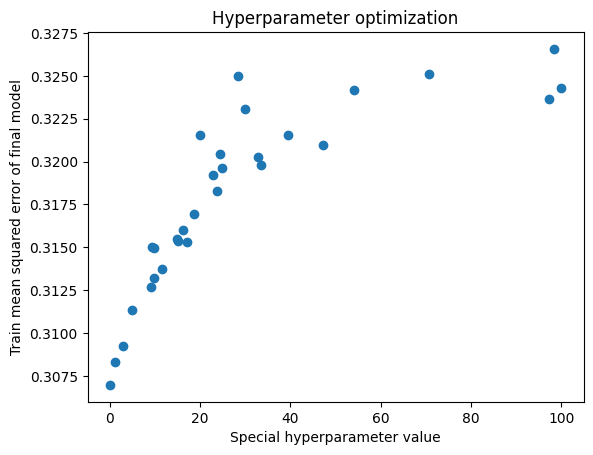

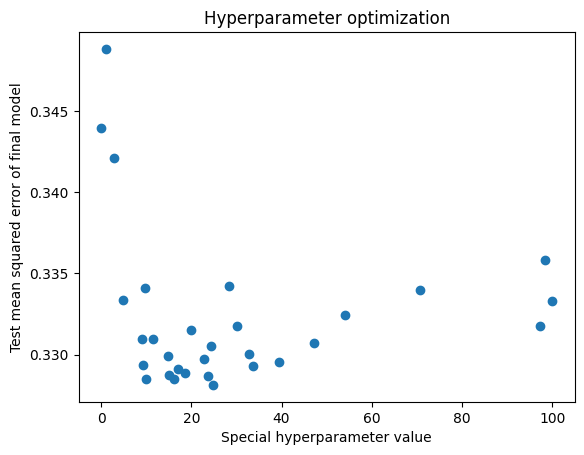

initializing
Training


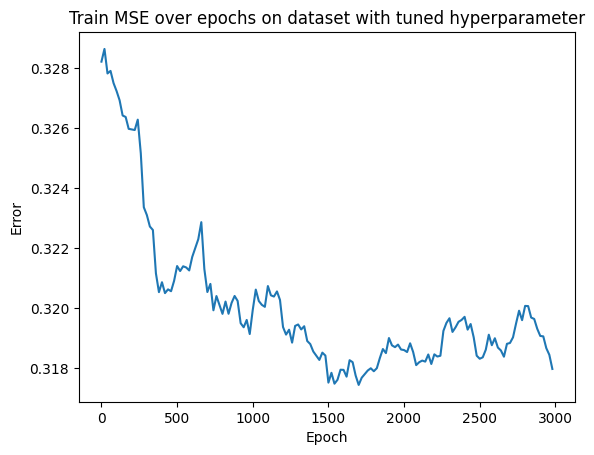

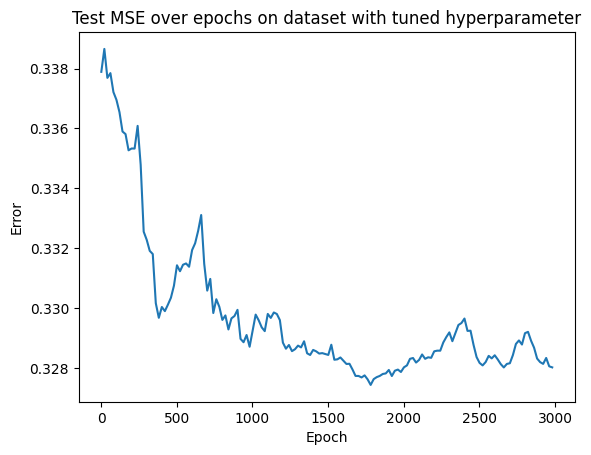

In [10]:
import optuna

class Model_2:
    def __init__(self, X: list[list[float]], y: list[float], store_errors: bool = False, special_hyperparameter=0, error_skip_length: int = 1, X_test: list[list[float]] = None, y_test: list[float] = None):
        assert len(X) > 0
        print("initializing")
        self.special_hyperparameter=special_hyperparameter
        self.store_errors = store_errors
        self.error_skip_length = error_skip_length
        self.errors_train = [] # Will store the MSE as a function of epochs 
        self.errors_test = []
        self.coefficients = [0 for i in range(len(X[0]))]
        self.y_intercept = numpy.mean(y)
        x_t = numpy.transpose(X)
        self.x_intercepts = []
        for column in range(len(x_t)):
            self.x_intercepts.append(numpy.mean(x_t[column]))
        
        #Normalize the data
        self.X = X.copy()
        for row in range(len(self.X)):
            self.normalize(self.X[row])
        self.y = y.copy()
        for i in range(len(self.y)):
            self.y[i] -= self.y_intercept

        self.X_test = X_test
        self.y_test = y_test
    #Normalize inputs
    def normalize(self, x: list[float]):
        assert len(x) == len(self.coefficients)
        for i in range(len(x)):
                x[i] -= self.x_intercepts[i]

    #Predict the normalized y value given normalized x values
    def predict_normalized(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        return numpy.dot(self.coefficients, x)


    #Predict the y value given x values
    def predict(self, x: list[float]) -> float:
        assert len(x) == len(self.coefficients)
        x_normalized = x.copy()
        self.normalize(x_normalized) #Normalize the input
        return self.predict_normalized(x_normalized) + self.y_intercept #Denormalize the output
    
    def fit(self, epochs: int, learning_rate: float):
        print("Training")
        self.errors_test = []
        self.errors_train = []
        for i in range(epochs):
                
            rand_index = random.randint(0, len(self.X)-1)
            x = self.X[rand_index]
            prediction = self.predict_normalized(x)
            #Now to update the weights
            for weight_index in range(len(self.coefficients)):
                gradient = 2*(prediction - self.y[rand_index])*x[weight_index] + self.special_hyperparameter * self.coefficients[weight_index]
                self.coefficients[weight_index] -= learning_rate * gradient

            # Calculate MSE for train and test data and store it
            # This is just for metrics, but unfortunately takes a vast majority
            # of the computational power in this algorithm.
            # As such, I have added an extra parameter, "error_skip_length"
            # This will be used so that it only finds and stores the MSE at every error_skip_length'th epoch.
            if self.store_errors and i % self.error_skip_length == 0:
                if self.X_test is not None and self.y_test is not None:
                    assert len(self.X_test) > 0
                    assert len(self.X_test[0]) == len(self.X[0])

                    predictions = []
                    for j in range(len(self.X_test)):
                        predictions.append(self.predict(self.X_test[j]))
                    mse = mean_squared_error(self.y_test, predictions)
                    #print("Epoch " + str(i + 1) + " test mse: " + str(mse))
                    self.errors_test.append(mean_squared_error(self.y_test, predictions))
     

                predictions = []
                for j in range(len(self.X)):
                    predictions.append(self.predict_normalized(self.X[j]))
                mse = mean_squared_error(self.y, predictions)
                #print("Epoch " + str(i + 1) + " train mse: " + str(mse))
                self.errors_train.append(mse)
            
train_errors = []
test_errors = []
def train_regressor(trial):
    special_hyperparameter = trial.suggest_float("special_hyperparameter", low = 0, high=100)
    model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter=special_hyperparameter)
    model.fit(3000, 0.0001)


    y_pred = []
    for i in range(len(X_train_transformed)):
        y_pred.append(model.predict(X_train_transformed[i]))
    error = mean_squared_error(y_train, y_pred)
    train_errors.append(error)

    y_pred = []
    for i in range(len(X_test_transformed)):
        y_pred.append(model.predict(X_test_transformed[i]))
    error = mean_squared_error(y_test, y_pred)
    test_errors.append(error)
    return error

study = optuna.create_study(direction='minimize')
study.optimize(train_regressor, n_trials=30)

plt.scatter([study.trials[i].params["special_hyperparameter"] for i in range(len(study.trials))], train_errors)
plt.xlabel("Special hyperparameter value")
plt.ylabel("Train mean squared error of final model")
plt.title("Hyperparameter optimization")
plt.show()

plt.scatter([study.trials[i].params["special_hyperparameter"] for i in range(len(study.trials))], test_errors)
plt.xlabel("Special hyperparameter value")
plt.ylabel("Test mean squared error of final model")
plt.title("Hyperparameter optimization")
plt.show()

error_skip_length = 20
final_model = Model_2(X_train_transformed, y_train_transformed, special_hyperparameter=study.best_params["special_hyperparameter"], store_errors=True, error_skip_length=error_skip_length, X_test=X_test_transformed, y_test=y_test_transformed)
final_model.fit(3000, 0.00007)
x_axis = [error_skip_length * i + 1 for i in range(len(final_model.errors_train))]
plt.plot(x_axis, final_model.errors_train)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Train MSE over epochs on dataset with tuned hyperparameter")
plt.show()

plt.plot(x_axis, final_model.errors_test)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Test MSE over epochs on dataset with tuned hyperparameter")
plt.show()

Wow that did not help much at all. Nevertheless, it was successfully incorporated and did not have a significantly detrimental effect on our model, which still shows a reduction in MSE after training. We can see that some values were bad for our training data performance, but good for our testing data performance. I cannot say that this definitively improved the model's performance overall. I'm sure that in another situation, this added functionality to the Model_2 class could prove useful.